# Graph-to-Simplicial Neighborhood Complex Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

NameError: name 'data' is not defined

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [41]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


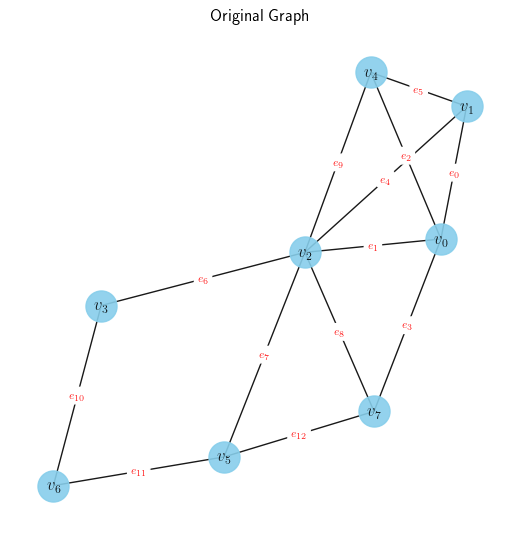

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [42]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we instantiate the lifting technique. For this particular case we are using the *neighbourhood complex* lifting. Given a graph $G = (V, E)$ we denote the vertex of $G$ as $V(G)$. Then the *neighbourhood complex* (a simplicial complex) $N(G)$ has as vertex the set $V(G)$ and as simplices the subsets of $V(G)$ that have a common neighbour.
Consequently, this lifts a graph to a simplicial complex of rank $k$ where the is the maximum amount of nodes with which it shares a neighbour. This definition follow from [[1]](https://www.sciencedirect.com/science/article/pii/0097316578900225). 

The maximum rank $r$ of the simplicial complex (denoting the simplex with highest cardinality) will be of the highest neighbourhood. The algorithm to compute this will inspect all nodes, all of it's neighbours and then check which nodes share this neighbours. This naive implementation's complexity is $\mathcal{O}(|V|^3)$, where the worst case is for complete graphs.


Note that we can set the parameter `complex_dim` as high as we like to limit the size of the neighbourhood that is taken into account since for well connected graphs this will explode exponentially for the number of simplices created. 

Additionally, this implementation uses the feature lifting technique `ElementwiseLifting` which exploits the property that a $r$-simplex will be composed of $r+1$ simplices of cardinality $r-1$. We will take the mean of the feature embedding of  the $i$-th component (node) of the lower rank simplices and the components of the $r$-simplex. So for the $0$-th components simplices of rank $0$ to $r$ are taken into account, for the $1$-th rank $1$ to $r$ and so on. Then the mean of those will represent the $r$-simplex embedding. We use padding to compute this in form of tensor operations.


***
[[1]](https://www.sciencedirect.com/science/article/pii/0097316578900225) L, Lovász. (1967). Kneser's conjecture, chromatic number, and homotopy
***

In [46]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2simplicial/neighborhood_complex_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2simplicial/neighborhood_complex_lifting:

{'transform_type': 'lifting',
 'transform_name': 'NeighborhoodComplexLifting',
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ElementwiseMean',
 'complex_dim': 5}


We than apply the transform via our `PreProcesor`:

Processing...
Done!


Transform parameters are the same, using existing data_dir: /Users/martincarrasco/Documents/VU/research/tdl/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/2778301543

Dataset only contains 1 sample:


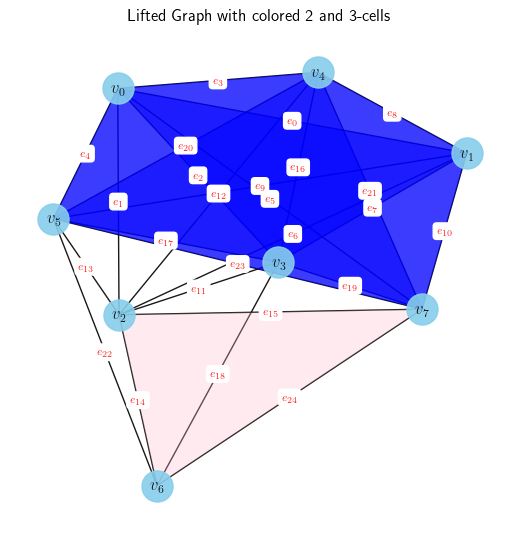

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 25 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 21 2-cells.
 - The 2-cells have features dimension 1
 - The complex has 15 3-cells.
 - The 3-cells have features dimension 1
 - The complex has 6 4-cells.
 - The 4-cells have features dimension 1



In [50]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir, force_reload=True)
describe_data(lifted_dataset)

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [20]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [52]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 